In [2]:
from dependencies.NN import *
from dependencies.LTL import *


from dependencies.csrl.mdp import GridMDP
from dependencies.csrl.oa import OmegaAutomaton
from dependencies.csrl import ControlSynthesis
import numpy as np
import os
from matplotlib import pyplot as plt

Number of Omega-automaton states (including the trap state): 5


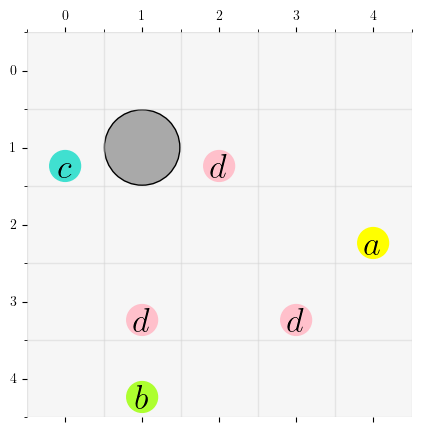

In [3]:
### from the Nursary case ###
# LTL Specification
# ltl = ('G ('
#     '(!d) & '
#     '((b & (!(X b)))->(X ((!b) U (a|c)))) & '
#     '(((!b) & (X b) & (!(X X b)))->((!a) U c)) & '
#     '(a->(X ((!a) U b))) & '
#     '(c->((!a) U b)) & '
#     '((b & (X b))->(F a))'
# ')')

ltl = ("(G !d) & ((!c) U b) & ((!b) U a) & (F c)")

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])

# MDP Description
shape = (5,5)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E',  'E',  'E'],
['E',  'B',  'E',  'E',  'E'],
['E',  'E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E',  'E']
])

# Labels of the states
label = np.array([
[(),    (),    (),    (),    ()],
[('c',),(),    ('d',),(),    ()],
[(),    (),    (),    (),    ('a',)],
[(),    ('d',),(),    ('d',),()],
[(),    ('b',),(),    (),    ()]
],dtype=object)
# Colors of the labels
lcmap={
    ('a',):'yellow',
    ('b',):'greenyellow',
    ('c',):'turquoise',
    ('d',):'pink'
}
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=1, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot()

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)


In [4]:
model = build_model(csrl.ch_states[(0,0,0,0)].shape, csrl.shape[-1])
model.summary()

2023-09-11 14:44:40.492647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 14:44:40.493125: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 5, 5)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 5, 5, 32)     672         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 5, 5, 8)      1032        ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 200)          0           ['conv2d_1[0][0]']               
                                                                                              

In [2]:
t = "[] ~d /\ (~c % b) /\ (~b % a) /\ (<> c)"

LTL_formula = parser.parse(t)
predicates={'a':[14], 'b':[21], 'c':[5], 'd':[7,16,18]}

In [ ]:
LTL_formula

('/\\',
 ('[]', ('~', (None, 'd'))),
 ('/\\',
  ('%', ('~', (None, 'c')), (None, 'b')),
  ('/\\', ('%', ('~', (None, 'b')), (None, 'a')), ('<>', (None, 'c')))))

In [ ]:
model(csrl.ch_states[(0,0,0,0)][np.newaxis])

N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)

In [ ]:

num_epochs = 20
training = True
T = 16
results = []
search_depths = [2,4,8,16,32,40,60,80,100,120,200] #[2,4,6,8,10,15,20,25,30,35,40,45,50,60,70,80,90,100,120]
for sd in search_depths:
    wins = 0
    N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)
    for epoch in range(num_epochs):
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = csrl.MC_learning(model, LTL_formula, predicates,
                N = N, W = W, Q = Q, P = P, C=3, tow=1, n_samples=sd,
                verbose=4,start=(0,0),T=T,K=3)
        if check_LTL(LTL_formula, trajectory, predicates)[0]:
            wins+=1
            print(check_LTL(LTL_formula, trajectory, predicates))

        if training:
            x_train = np.array(channeled_states)
            y1_train = np.array(better_policy)
            y2_train = np.array(reward_history) + (check_LTL(LTL_formula, trajectory, predicates)[0]*max_rew)
            model.fit(x_train[:-1], [y1_train, y2_train[:-1]], epochs=20, verbose=0)

    ###############################################################
    print("Wins:",wins,"/",num_epochs)
    print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    print("Actions:", action_history)
    results.append(wins)

trajectory: [0, 0, 5, 5, 10, 11, 12, 13, 14, 9, 14, 14, 19, 24, 19, 24]
action_history: [3, 1, 3, 1, 2, 2, 2, 2, 0, 1, 2, 1, 1, 0, 1]
state history: [(0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 1, 0), (0, 4, 1, 0), (0, 4, 2, 0), (0, 4, 2, 1), (0, 4, 2, 2), (0, 4, 2, 3), (0, 4, 2, 4), (0, 4, 1, 4), (0, 4, 2, 4), (0, 4, 2, 4), (0, 4, 3, 4), (0, 4, 4, 4), (0, 4, 3, 4), (0, 4, 4, 4)]
----------
trajectory: [0, 0, 0, 5, 5, 10, 11, 11, 12, 11, 12, 13, 14, 19, 24, 23]
action_history: [0, 3, 1, 3, 1, 2, 0, 2, 3, 2, 2, 2, 1, 1, 3]
state history: [(0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 1, 0), (0, 4, 1, 0), (0, 4, 2, 0), (0, 4, 2, 1), (0, 4, 2, 1), (0, 4, 2, 2), (0, 4, 2, 1), (0, 4, 2, 2), (0, 4, 2, 3), (0, 4, 2, 4), (0, 4, 3, 4), (0, 4, 4, 4), (0, 4, 4, 3)]
----------
trajectory: [0, 5, 5, 0, 1, 1, 1, 0, 5, 10, 5, 0, 0, 0, 1, 2]
action_history: [1, 3, 0, 2, 1, 0, 3, 1, 1, 0, 0, 0, 3, 2, 2]
state history: [(0, 0, 0, 0), (0, 0, 1, 0), (0, 4, 1, 0), (0, 4, 0, 0), (0, 4, 0, 1), (0, 4, 0, 1), (0, 4,

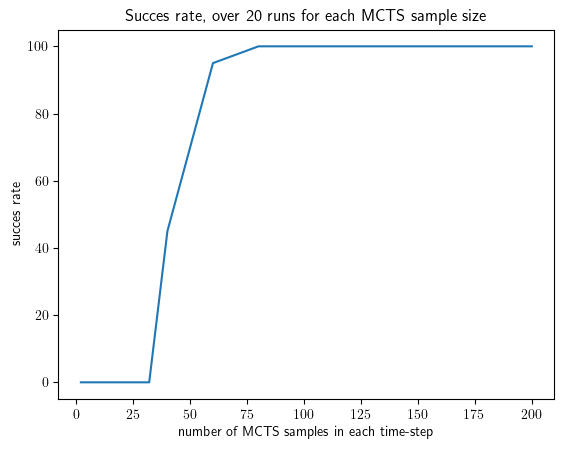

In [ ]:
plt.plot(search_depths, [r*5 for r in results])
plt.xlabel("number of MCTS samples in each time-step")
plt.ylabel("succes rate")
plt.title("Succes rate, over 20 runs for each MCTS sample size")
plt.savefig('line_plot2.pdf') 

In [3]:
from ipywidgets.widgets import IntSlider
from ipywidgets import interact

In [ ]:
def plot_agent(t):
    csrl.mdp.plot(agent=state_history[t][2:], save=f'test/{t}.png')
t=IntSlider(value=0,min=0,max=T-1)
interact(plot_agent,t=t)

interactive(children=(IntSlider(value=0, description='t', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_agent(t)>

In [ ]:
os.system('ffmpeg -r 3 -i ./test/%d.png -vcodec libx264 -y ./test/test.mp4')

1

In [4]:
np.array([0, 14, 85, 86, 80, 85, 83, 85])/87

array([0.        , 0.16091954, 0.97701149, 0.98850575, 0.91954023,
       0.97701149, 0.95402299, 0.97701149])

In [4]:
# SP4LTL
T = [25, 50, 100, 200, 400]
success_rates= [93, 95, 92, 96, 95]

succes_std = []
for i in success_rates:
    temp = np.zeros(100)
    temp[:int(i)]=1
    std = np.sqrt(100*np.var(temp))
    print(std)
    succes_std.append((i-std, i+std))

2.551470164434615
2.179449471770337
2.7129319932501073
1.9595917942265424
2.179449471770337


In [32]:
x = [
    [52, 65, 55, 50, 49],
    [53, 48, 59, 51, 64],
    [48, 55, 54, 47, 56]
]

np.mean(x, 0)

array([51.        , 56.        , 56.        , 49.33333333, 56.33333333])

[97, 100, 98, 99, 100, 99, 99, 100]

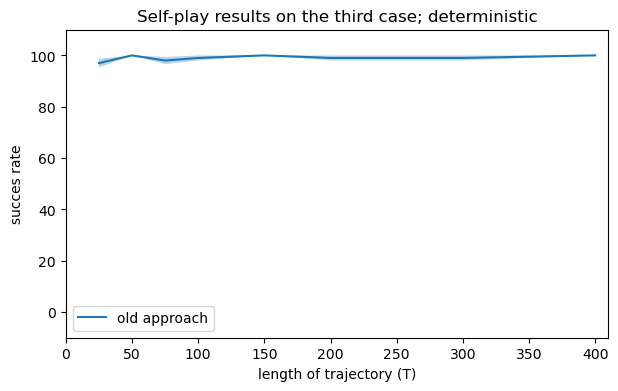

In [28]:
succes_std = np.array(succes_std)

plt.figure(figsize=(7,4))
plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3)

plt.plot(T, success_rates, label='old approach')
plt.xlabel("length of trajectory (T)")
plt.ylabel(f"succes rate")
# plt.title("Self-play results on the third case; stochastic")
plt.title("Self-play results on the third case; deterministic")
plt.ylim(-10, 110)
plt.xlim(0, 410)
plt.savefig(f"res_400/C3_P{p}.pdf")
plt.legend()
success_rates

In [17]:
# CSRL
T2 = [25, 50, 100, 200, 400]
success_rates2= [97, 100, 95, 96, 92]
succes_std2 = []
for i in success_rates2:
    temp = np.zeros(100)
    temp[:int(i)]=1
    std = np.sqrt(100*np.var(temp))
    print(std)
    succes_std2.append((i-std, i+std))

1.705872210923198
0.0
2.179449471770337
1.9595917942265424
2.7129319932501073


In [15]:
a = [[4 for i in range(37)] + [3 for i in range(13)],
     [7 for i in range(30)] + [6 for i in range(20)],
     [15 for i in range(50)],
     [33 for i in range(48)] + [32 for i in range(2)]]
    
for i in np.array(a):
    print((i[i>0]).mean(), np.sqrt(np.var((i[i>0]))))

3.74 0.4386342439892262
6.6 0.4898979485566356
15.0 0.0
32.96 0.19595917942265423


In [25]:
p=1
case=3

[93, 95, 92, 96, 92, 95, 95, 98]

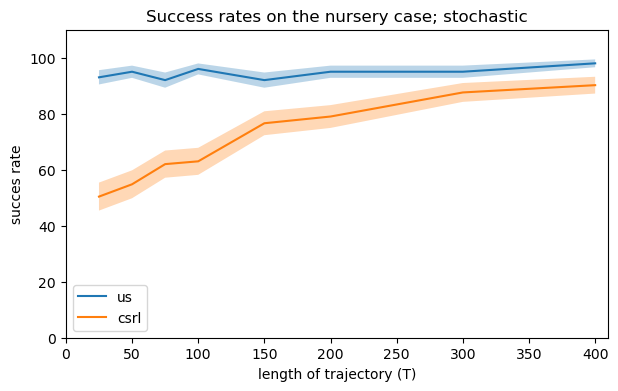

In [26]:
succes_std = np.array(succes_std)
succes_std2 = np.array(succes_std2)

plt.figure(figsize=(7,4))
plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3)
plt.fill_between(T2, succes_std2[:,0], succes_std2[:,1], alpha=0.3)

plt.plot(T, success_rates, label='us')
plt.plot(T2, success_rates2, label='csrl')
plt.xlabel("length of trajectory (T)")
plt.ylabel(f"succes rate")
# plt.title("Success rates on the nursery case; stochastic")
# plt.title("Success rates on the safe absorbing case; deterministic")
plt.ylim(0, 110)
plt.xlim(0, 410)
plt.legend()
# plt.savefig(f"results/C{case}_comp_p={p}.pdf")
# plt.savefig(f"results/C{case}_comp_p={p}.pdf")
success_rates

In [ ]:
T = [25, 50, 100, 150, 200, 300, 400]
acc_rews = [0.01, 0.04, 0.07, 0.12, 0.16, 0.21, 0.32]

plt.figure(figsize=(7,4))
plt.plot(T, acc_rews, label='us')
plt.plot(T, csrl_acc_rews, label='csrl')
plt.ylim(0, 110)
plt.xlim(0, 410)
plt.legend()

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

C:\Users\pc-admin\AppData\Local\Temp\ipykernel_21148\2869943138.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


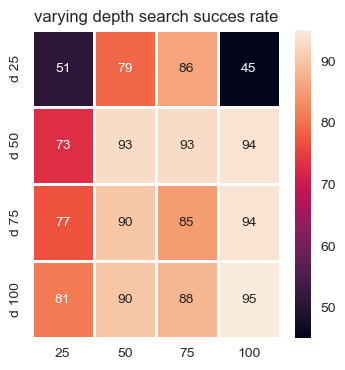

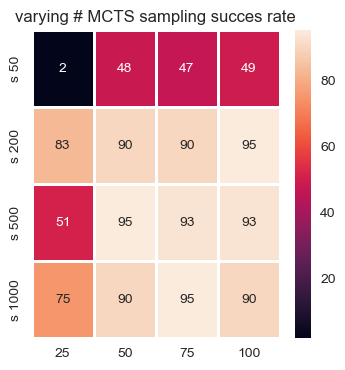

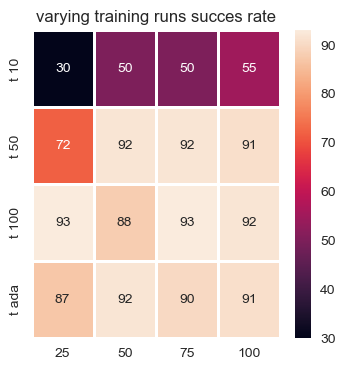

In [ ]:
plt.style.use("seaborn")
 
# 2. Generate a 10x10 random integer matrix
data = [
    [51, 79, 86, 45],
    [73, 93, 93, 94],
    [77, 90, 85, 94],
    [81, 90, 88, 95]
]
 
# 3. Plot the heatmap
plt.figure(figsize=(4,4))
heat_map = sns.heatmap( data, linewidth = 1 , annot = True, xticklabels=[25, 50, 75, 100], yticklabels=['d 25', 'd 50', 'd 75', 'd 100'])
plt.title("varying depth search succes rate")
plt.show()

data = [
    [2, 48, 47, 49],
    [83, 90, 90, 95],
    [51, 95, 93, 93],
    [75, 90, 95, 90]
]
 
# 3. Plot the heatmap
plt.figure(figsize=(4,4))
heat_map = sns.heatmap( data, linewidth = 1 , annot = True, xticklabels=[25, 50, 75, 100], yticklabels=['s 50','s 200', 's 500', 's 1000'])
plt.title("varying # MCTS sampling succes rate")
plt.show()

data = [
    [30, 50, 50, 55],
    [72, 92, 92, 91],
    [93, 88, 93, 92],
    [87, 92, 90, 91],
]
 
# 3. Plot the heatmap
plt.figure(figsize=(4,4))
heat_map = sns.heatmap( data, linewidth = 1 , annot = True, xticklabels=[25, 50, 75, 100], yticklabels=['t 10', 't 50', 't 100', 't ada'])
plt.title("varying training runs succes rate")
plt.show()

C:\Users\pc-admin\AppData\Local\Temp\ipykernel_21148\908381384.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


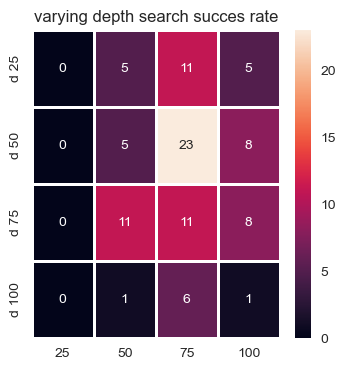

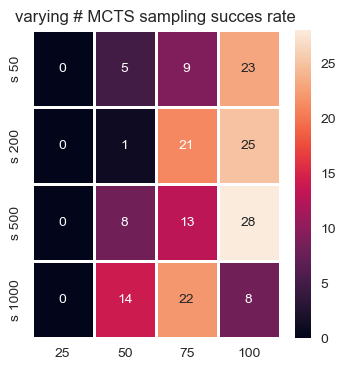

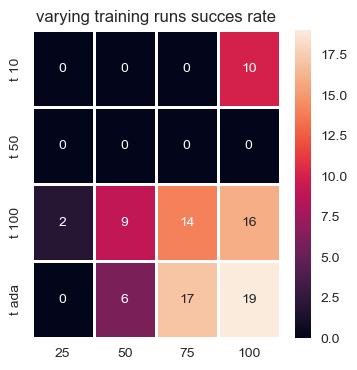

In [ ]:
plt.style.use("seaborn")
 
# 2. Generate a 10x10 random integer matrix
data = [
    [0, 5, 11, 5],
    [0, 5, 23, 8],
    [0, 11, 11, 8],
    [0, 1, 6, 1]
]
 
# 3. Plot the heatmap
plt.figure(figsize=(4,4))
heat_map = sns.heatmap( data, linewidth = 1 , annot = True, xticklabels=[25, 50, 75, 100], yticklabels=['d 25', 'd 50', 'd 75', 'd 100'])
plt.title("varying depth search succes rate")
plt.show()

data = [
    [0, 5, 9, 23],
    [0, 1, 21, 25],
    [0, 8, 13, 28],
    [0, 14, 22, 8]
]
 
# 3. Plot the heatmap
plt.figure(figsize=(4,4))
heat_map = sns.heatmap( data, linewidth = 1 , annot = True, xticklabels=[25, 50, 75, 100], yticklabels=['s 50','s 200', 's 500', 's 1000'])
plt.title("varying # MCTS sampling succes rate")
plt.show()

data = [
    [0, 0, 0, 10],
    [0, 0, 0, 0],
    [2, 9, 14, 16],
    [0, 6, 17, 19],
]
 
# 3. Plot the heatmap
plt.figure(figsize=(4,4))
heat_map = sns.heatmap( data, linewidth = 1 , annot = True, xticklabels=[25, 50, 75, 100], yticklabels=['t 10', 't 50', 't 100', 't ada'])
plt.title("varying training runs succes rate")
plt.show()

In [14]:
X = [
    [0,0,0,10],
    [0,0,0,0],
    [2,9,14,16],
    [0,6,17,19]
]
for success_rates in X:
    succes_std = []
    for i in success_rates:
        temp = np.zeros(100)
        temp[:int(i)]=1
        std = np.sqrt(100*np.var(temp))
        succes_std.append(std)
    x = [f'{success_rates[i]}\textpm{round(succes_std[i], 2)} &' for i in range(len(success_rates))]
    print(x)

['0\textpm0.0 &', '0\textpm0.0 &', '0\textpm0.0 &', '10\textpm3.0 &']
['0\textpm0.0 &', '0\textpm0.0 &', '0\textpm0.0 &', '0\textpm0.0 &']
['2\textpm1.4 &', '9\textpm2.86 &', '14\textpm3.47 &', '16\textpm3.67 &']
['0\textpm0.0 &', '6\textpm2.37 &', '17\textpm3.76 &', '19\textpm3.92 &']


In [3]:
['2\textpm1.4 &', '48\textpm5.0 &', '47\textpm4.99 &', '49\textpm5.0 &']
['83\textpm3.76 &', '90\textpm3.0 &', '90\textpm3.0 &', '95\textpm2.18 &']
['51\textpm5.0 &', '95\textpm2.18 &', '93\textpm2.55 &', '93\textpm2.55 &']
['75\textpm4.33 &', '90\textpm3.0 &', '95\textpm2.18 &', '90\textpm3.0 &']

[(95.2941277890768, 98.7058722109232),
 (100.0, 100.0),
 (100.0, 100.0),
 (100.0, 100.0),
 (100.0, 100.0),
 (100.0, 100.0),
 (100.0, 100.0)]